**This notebook is the executable version of lab note 3.
It answers the following questions:**

Finally, we answer 4 items:

    1. Are successful creators more connected to high-outdegree users than do unsuccessful creators?
    2. Are mavens more connected to successful creators than to unsuccessful creators?
    3. Do successful creators send more non-follow actions towards mavens than to zombies?
    4. Do successful creators send more non-follow actions towards mavens than to stars?

    

In [1]:
#Run parameters
#used to control every run. Can be user to perfom sensitivity checks
path_dir = r"/Users/../Volumes/Raw/"

low_success = 0.5 #below the median: unsuccessful
high_success = 0.9 #top 10% creators with more followers are deemed successful

low_user_outdegree = 0.25 
high_user_outdegree = 0.75
low_user_activity = 0.25 
high_user_activity = 0.75 
low_user_indegree = 0.25 
high_user_outdegree = 0.75 

activity_filter = 0
days_delta = 7

In [2]:
import sys  
import pickle
sys.path.insert(0, '/Users/caiorego/Desktop/BDS/RA/Seeding-Bandits/')
import numpy as np
import src.utils
from collections import Counter
from src.utils import import_dta, import_tracks_dta,\
gen_active_relations, get_fan_interactions_per_week, calculate_avg_monthly_valence,\
gen_active_relations_prob, get_fan_interactions_per_week_prob, stripplot_prob,\
reaction_probability, follower_list, filter_quantile, sample_creators_music,\
gen_outbound_creators
import numpy as np
import datetime
import pandas as pd
from tqdm import tqdm
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy
import os
from statsmodels.stats.proportion import proportions_ztest

In [3]:
def process_date(date):
    '''convert date format like '2013-w09' to '2013-03-04', i.e. the first day of that week'''
    year = date[0:4]
    week = date[6:]
    day = "1"
    date = "{}-{}-1".format(year, week)
    dt = datetime.datetime.strptime(date, "%Y-%W-%w")
    return dt

# Data Imports

We start by importing the raw data.  `follows_sent`, `comments_sent`, `shares_sent`, `likes_sent` and `messages_sent` contains data pn the promotional activities that the 35k users tracked in the dataset directed to other users. It includes the `user_id`, the `fan_id` and the `date_sent` which identifies the date when the prom. activity was sent. `users_info_1st` shows the type of user (creator or non-creator, which is identified by a blank) and the date the user entered the platform, for every user that sent or received prom. activities from any of the 35k users tracked in this dataset, while `users_info` contains the same information, but pertaining to the 35k users themselves.

`follows_received` contains information on the follows received by the 35k users and will be used to generate the successful/unsuccessful groups of content creators.

In [4]:
#affiliations :follows
#favoritings :likes

#used in filtering:
path_dir = r"/Users/../Volumes/Raw/"
tracks = import_tracks_dta(path_dir, "12sample_tracks.dta");

#these are the actions sent to 
follows_sent = import_dta(path_dir, "12sample_affiliations_sent.dta");
comments_sent = import_dta(path_dir, "12sample_comments_made.dta");
shares_sent = import_dta(path_dir, "12sample_reposts_made.dta");
likes_sent = import_dta(path_dir, "12sample_favoritings_made.dta");
messages_sent = import_dta(path_dir, "12sample_messages_sent.dta");

#Used to track information on the 1st degree connections
user_info_1st = import_dta(path_dir, "12sample_1st_deg_user_infos.dta");
user_info_1st.columns = ['user_id', 'type', 'entered_platform'];
user_info = import_dta(path_dir, "12sample_user_infos.dta");

#Used to compute creator's success measure
follows_received = import_dta(path_dir, "12sample_affiliations_received.dta");

%%%%%%%%%% 12sample_tracks.dta %%%%%%%%%%
(56262, 7)
%%%%%%%%%% 12sample_affiliations_sent.dta %%%%%%%%%%
(800913, 3)
%%%%%%%%%% 12sample_comments_made.dta %%%%%%%%%%
(29258, 4)
%%%%%%%%%% 12sample_reposts_made.dta %%%%%%%%%%
(179329, 4)
%%%%%%%%%% 12sample_favoritings_made.dta %%%%%%%%%%
(527701, 4)
%%%%%%%%%% 12sample_messages_sent.dta %%%%%%%%%%
(11091, 3)
%%%%%%%%%% 12sample_1st_deg_user_infos.dta %%%%%%%%%%
(670746, 3)
%%%%%%%%%% 12sample_user_infos.dta %%%%%%%%%%
(35000, 3)
%%%%%%%%%% 12sample_affiliations_received.dta %%%%%%%%%%
(432503, 3)


Indegree and outdegree information.

The function below import the outdegree dataset. Because the raw version of those dataset are too large to be processed in memory, we preprocessed them in a separate script.

In [5]:
# imports the preprocessed indegree data.
# the data was previously split in 9 pickeld pd.dataframes for memory reasons
def import_indegree_dask(path='/Users/caiorego/Desktop/BDS/RA/Seeding-Bandits/indegree/'):
    df = pd.read_pickle('{}df0.pkl'.format(path))
    df1 = pd.read_pickle('{}df1.pkl'.format(path))
    df2 = pd.read_pickle('{}df2.pkl'.format(path))
    df3 = pd.read_pickle('{}df3.pkl'.format(path))
    df4 = pd.read_pickle('{}df4.pkl'.format(path))
    df5 = pd.read_pickle('{}df5.pkl'.format(path))
    df6 = pd.read_pickle('{}df6.pkl'.format(path))
    df7 = pd.read_pickle('{}df7.pkl'.format(path))
    df8 = pd.read_pickle('{}df8.pkl'.format(path))
    df9 = pd.read_pickle('{}df9.pkl'.format(path))
     
    #convert pd.dataframe to dask.dataframe, which better suits big data.
    ddf = dd.from_pandas(df, npartitions = 3)
    ddf1 = dd.from_pandas(df1, npartitions = 3)
    ddf2 = dd.from_pandas(df2, npartitions = 3)
    ddf3 = dd.from_pandas(df3, npartitions = 3)
    ddf4 = dd.from_pandas(df4, npartitions = 3)
    ddf5 = dd.from_pandas(df5, npartitions = 3)
    ddf6 = dd.from_pandas(df6, npartitions = 3)
    ddf7 = dd.from_pandas(df7, npartitions = 3)
    ddf8 = dd.from_pandas(df8, npartitions = 3)
    ddf9 = dd.from_pandas(df9, npartitions = 3)
    
    concatdf = dd.multi.concat([ddf,ddf1,ddf2,ddf3,ddf4,ddf5,ddf6,ddf7,ddf8,ddf9])
    data = concatdf.compute()
    
    return data

In [8]:
data_indegree = import_indegree_dask()
data_indegree = data_indegree.groupby('contact_id',as_index = False)['size'].sum()

In [11]:
table_data = pd.read_csv('user_types_ids.csv', index_col = 0)

In [12]:
hermit_ids = table_data.loc[table_data.Type =='Hermit'].user_id.unique()
w_a_ids = table_data.loc[table_data.Type =='w_a'].user_id.unique()
f_a_ids = table_data.loc[table_data.Type =='f_a'].user_id.unique()
observer_ids = table_data.loc[table_data.Type =='Observer'].user_id.unique()

In [13]:
analysis_data = table_data.merge(data_indegree, left_on = 'user_id', right_on = 'contact_id')
analysis_data.columns  = ['user_id', 'followers', 'outdegree_level', 'activities_performed',
       'activity_level', 'Type', 'contact_id', 'indegree']

In [16]:
analysis_data.groupby('Type', as_index = False).agg({'indegree': 'mean'})

,Type,indegree
0,Hermit,822.140866
1,Observer,2918.636746
2,f_a,45745.371997
3,other,2007.810397
4,w_a,2601.662344


In [17]:
low = np.quantile(analysis_data.indegree, 0.25)
high = np.quantile(analysis_data.indegree, 0.75)

low_indegree_ids = analysis_data.loc[analysis_data["indegree"] <= low].user_id.unique()
high_indegree_ids = analysis_data.loc[analysis_data["indegree"] >= high].user_id.unique()
    
analysis_data['indegree_level'] = analysis_data.user_id.apply(
        lambda x: 'high' if x in high_indegree_ids else ('low' if x in low_indegree_ids else None))
analysis_data['indegree_level'] = analysis_data.indegree_level.apply(lambda x: 'other' if x is None else x)

In [18]:
low

13.0

In [19]:
high

177.0

In [20]:
round(pd.crosstab(analysis_data['Type'], analysis_data['indegree_level'], normalize = 'index')*100,2).T


Type,Hermit,Observer,f_a,other,w_a
indegree_level,,,,,
high,7.91,18.63,32.54,18.87,71.2
low,37.38,22.04,30.25,29.41,0.3
other,54.71,59.32,37.21,51.72,28.5


In [21]:
analysis_data.to_csv('indegree_level.csv')

In [22]:
analysis_data.indegree.describe()

count    6.636920e+05
mean     2.459901e+03
std      7.174555e+04
min      1.000000e+00
25%      1.300000e+01
50%      3.700000e+01
75%      1.770000e+02
max      8.440637e+06
Name: indegree, dtype: float64

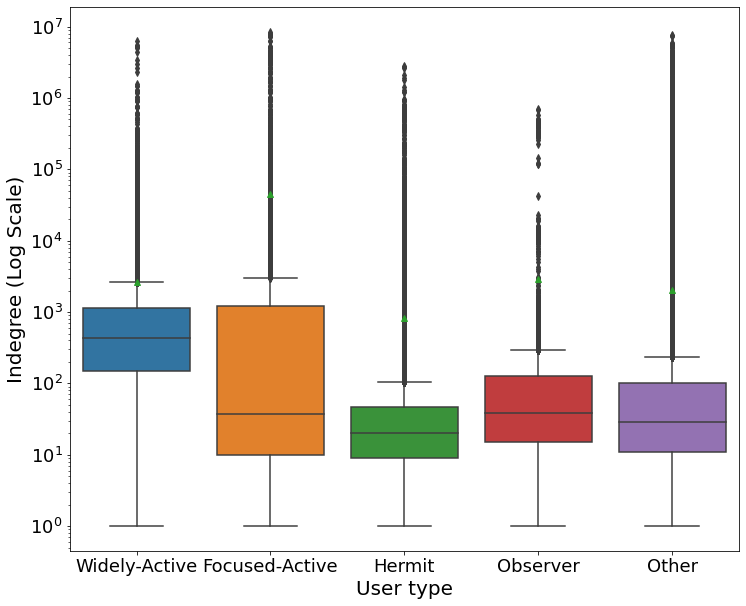

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
df = analysis_data
# Set the size of the figure
plt.figure(figsize=(12, 10))  # Adjust the width and height as needed

# Specify the desired order of the categories
category_order = ['w_a', 'f_a', 'Hermit', 'Observer', 'other']

# Assuming your data is stored in a pandas DataFrame called 'df'
sns.boxplot(data=df, x='Type', y='indegree', order=category_order, showmeans=True)

# Set the y-axis scale to logarithmic
plt.yscale('log')

# Add labels and title to the plot
plt.xlabel('User type', fontsize=20)
plt.ylabel('Indegree (Log Scale)', fontsize=20)

# Customize x-tick labels
x_tick_labels = ['Widely-Active', 'Focused-Active', 'Hermit', 'Observer', 'Other']  # Add your custom labels here
plt.xticks(ticks=plt.xticks()[0], labels=x_tick_labels, fontsize=18)
plt.yticks(fontsize=18)

# Display the plot
plt.show()


In [31]:
analysis_data.groupby('Type').agg({'indegree': ['mean', 'median']})

indegree       
                  mean median
Type                         
Hermit      822.140866   20.0
Observer   2918.636746   39.0
f_a       45745.371997   37.0
other      2007.810397   29.0
w_a        2601.662344  428.0